### Energy Economics Code 
####  Morten Rasmussen, Christian Sørensen 
Spring 2019 

#### Preamble

In [9]:
# In this cell, we import a number of packages that are used in the course of this analysis. This cell must always be run first.
import csv
from urllib.request import urlretrieve

import matplotlib.pyplot as plt
from datetime import datetime
import xlrd
import numpy as np
import pandas as pd

from scipy.stats import norm

import random
from scipy.interpolate import interp1d
import seaborn as sns; sns.set()
import statsmodels.api as sm 

from statsmodels.formula.api import ols 
from statsmodels.iolib.summary2 import summary_col
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AR

#### Data gathering and cleaning

In [3]:
# This cell extracts data on i) wind forecasts, ii) production, 
# iii) volume and iv) consumptions prognosis from nordpoolgroup.com
# This cell only has to be run if the file data_nordpool.pkl is not currently in the directory.
forecast_data = []
for x in range(2013, 2018):
    url = 'https://www.nordpoolgroup.com/globalassets/marketdata-excel-files/wind-power-dk-prognosis_'+str(x)+'_hourly.xls'
    urlretrieve(url,'wind-power-dk-prognosis_'+str(x)+'_hourly.xls')
    filename='wind-power-dk-prognosis_'+str(x)+'_hourly.xls'
    data= pd.read_html(filename)
    data=pd.DataFrame(data[0])
    data.columns=['date','time', 'DK_vest_forecast', 'DK_øst_forecast']
    forecast_data.append(data)

forecast_data = pd.concat(forecast_data, axis=0)

# Retrieve production data from nordpoolgroup.com
production_data = []
for x in range(2013, 2018):
    url = 'https://www.nordpoolgroup.com/globalassets/marketdata-excel-files/wind-power-dk_'+str(x)+'_hourly.xls'
    urlretrieve(url,'wind-power-dk_'+str(x)+'_hourly.xls')
    filename='wind-power-dk_'+str(x)+'_hourly.xls'
    data= pd.read_html(filename)
    data=pd.DataFrame(data[0])
    data.columns=['date','time', 'DK_vest_production', 'DK_øst_production']
    production_data.append(data)

production_data = pd.concat(production_data, axis=0)


# Retrieve volume data from nordpoolgroup.com
volume_data = []
for x in range(2013, 2018):
    url = 'https://www.nordpoolgroup.com/globalassets/marketdata-excel-files/production-dk-areas_'+str(x)+'_hourly.xls'
    urlretrieve(url,'production-dk-areas_'+str(x)+'_hourly.xls')
    filename='production-dk-areas_'+str(x)+'_hourly.xls'
    data= pd.read_html(filename)
    data=pd.DataFrame(data[0])
    data.columns=['date','time', 'DK_vest_volume', 'DK_øst_volume','DK_volume']
    volume_data.append(data)

volume_data = pd.concat(volume_data, axis = 0)

C_prognosis_data = []
for x in range(2013,2018):
    url = 'https://www.nordpoolgroup.com/globalassets/marketdata-excel-files/consumption-prognosis_'+str(x)+'_hourly.xls'
    urlretrieve(url,'C_prognosis-dk-areas_'+str(x)+'_hourly.xls')
    filename='C_prognosis-dk-areas_'+str(x)+'_hourly.xls'
    data= pd.read_html(filename)
    data=pd.DataFrame(data[0])
    data=data.iloc[:,[0,1,5,6]]
    data.columns=['date','time', 'DK_vest_c_prognosis', 'DK_øst_c_prognosis']
    C_prognosis_data.append(data)

C_prognosis_data = pd.concat(C_prognosis_data, axis = 0)

# Merge forecast and production data, and extract year, month, weekday, hour:
data = pd.merge(forecast_data, production_data, on=['date','time'])
data = pd.merge(data, volume_data, on = ['date', 'time'])
data = pd.merge(data, C_prognosis_data, on = ["date", "time"], indicator = True)

data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.date

data['month'] = pd.DatetimeIndex(data['date']).month
data['day'] = pd.DatetimeIndex(data['date']).day
data['year'] = pd.DatetimeIndex(data['date']).year
data['weekday'] = pd.DatetimeIndex(data['date']).weekday
data['hour']=data['time'].str.slice(0, 2)
data.hour = data.hour.astype(int)

# Calculate forecasting error in each price area
data['forecasting_error_øst']=data['DK_øst_production'] - data['DK_øst_forecast']
data['forecasting_error_vest']=data['DK_vest_production'] - data['DK_vest_forecast']

data['wind_share_vest']=data['DK_vest_production']/data['DK_vest_volume']
data['wind_share_øst']=data['DK_øst_production']/data['DK_øst_volume']

data['wind_share_total_vest']=data['DK_vest_production']/data['DK_volume']
data['wind_share_total_øst']=data['DK_øst_production']/data['DK_volume']

# Forecasting error shares (i.e. what share of total volume does the forecasting error represent)

data["forecasting_error_share_vest"] = data["forecasting_error_vest"]/data["DK_vest_volume"]
data["forecasting_error_share_øst"] = data["forecasting_error_øst"]/data["DK_øst_volume"]

data["forecasting_error_share_cprog_vest"] = data["forecasting_error_vest"]/data["DK_vest_c_prognosis"]
data["forecasting_error_share_cprog_øst"] = data["forecasting_error_øst"]/data["DK_øst_c_prognosis"]

# Save the DataFrame as a .pkl file:
data.to_pickle("data_nordpool.pkl")

#### Load dataset from local directory

In [2]:
# If the file data_nordpool.pkl is in the directory, start from here. 
data = pd.read_pickle("data_nordpool.pkl")
data.drop(labels = "_merge", axis = 1, inplace = True)

# Split data sets according to price area
data_vest = data[['date','hour','day','weekday','year', 'month',
                  'DK_vest_production','DK_vest_forecast','forecasting_error_vest','DK_vest_volume',
                  'wind_share_vest','wind_share_total_vest',"forecasting_error_share_vest",
                  "forecasting_error_share_cprog_vest"]]

data_øst = data[['date','hour','day','weekday','year','month', 
                 'DK_øst_production','DK_øst_forecast','forecasting_error_øst','DK_øst_volume',
                 'wind_share_øst','wind_share_total_øst',"forecasting_error_share_øst",
                 "forecasting_error_share_cprog_øst"]]


#### Import price data and calculate relevant measures

In [3]:
# Load market data from energidataservice. Note, that this reads from a local file .xlsx file. 
# Key variables are Elbas price (min, max, avg), spot prices and date (hourly)
prices= pd.read_excel("Nordpool_Market_Data.xlsx")
prices['date'] = pd.to_datetime(prices['HourDK'])
prices['hour'] = pd.DatetimeIndex(prices['date']).hour
prices['date'] = prices['date'].dt.date
prices['price_diff'] = prices["ElbasAveragePriceDKK"]-prices["SpotPriceDKK"]

# Construct dataset pertaining to each price area:
prices_vest = prices[prices['PriceArea'] == 'DK1']
prices_øst = prices [prices['PriceArea'] == 'DK2']

# Merge price-data with wind-data: 
final_vest = pd.merge(prices_vest, data_vest, on = ['date','hour'], indicator = True)
final_øst = pd.merge(prices_øst, data_øst, on = ['date', 'hour'], indicator = True)
final = pd.merge(prices, data, on = ['date','hour'])

# Check that merge is successful 
print(final_vest["_merge"].describe())
print(final_øst["_merge"].describe())

final_vest["hour"] = final_vest["hour"].astype(str).astype(int) 
final_øst["hour"] = final_øst["hour"].astype(str).astype(int)
# Since we ultimately care about the adjustment, i.e. the price difference between day-ahead ("spot") and
# the Elbas price, we set the difference to zero in the case that the Elbas price is missing. 

# We start by filling with zeros: 
final_vest['ElbasAveragePriceDKK']=final_vest['ElbasAveragePriceDKK'].fillna(0)
final_øst["ElbasAveragePriceDKK"] = final_øst["ElbasAveragePriceDKK"].fillna(0)

# Adjust to numeric
final_vest['ElbasAveragePriceDKK'] = pd.to_numeric(final_vest['ElbasAveragePriceDKK'])
final_øst["ElbasAveragePriceDKK"] = pd.to_numeric(final_øst["ElbasAveragePriceDKK"])

# Calculate price differences
final_vest["price_diff"] = final_vest["ElbasAveragePriceDKK"] - final_vest["SpotPriceDKK"]
final_øst["price_diff"] = final_øst["ElbasAveragePriceDKK"] - final_vest["SpotPriceDKK"]

# Set price differences to zero if there's no info on Elbas price. 
final_øst.loc[final_øst["ElbasAveragePriceDKK"] == 0, "price_diff"] = 0
final_vest.loc[final_vest["ElbasAveragePriceDKK"] == 0, "price_diff"] = 0

# Construct outliers
final_vest["outlier"] = 0
final_øst["outlier"] = 0

final_vest.loc[final_vest["SpotPriceDKK"] > 2000, "outlier"] = 1
final_øst.loc[final_øst["SpotPriceDKK"] > 2000, "outlier"] = 1

# Print the number of outliers
print("the number of outliers in DK1 are: {}".format(final_vest["outlier"].sum()))
print("the number of outliers in DK2 are: {}".format(final_øst["outlier"].sum()))

# To view the actual outliers, use:
# final_vest.loc[final_vest["outlier"] == 1].head()


count     43974
unique        1
top        both
freq      43974
Name: _merge, dtype: object
count     43974
unique        1
top        both
freq      43974
Name: _merge, dtype: object
the number of outliers in DK1 are: 5
the number of outliers in DK2 are: 0


#### Figures

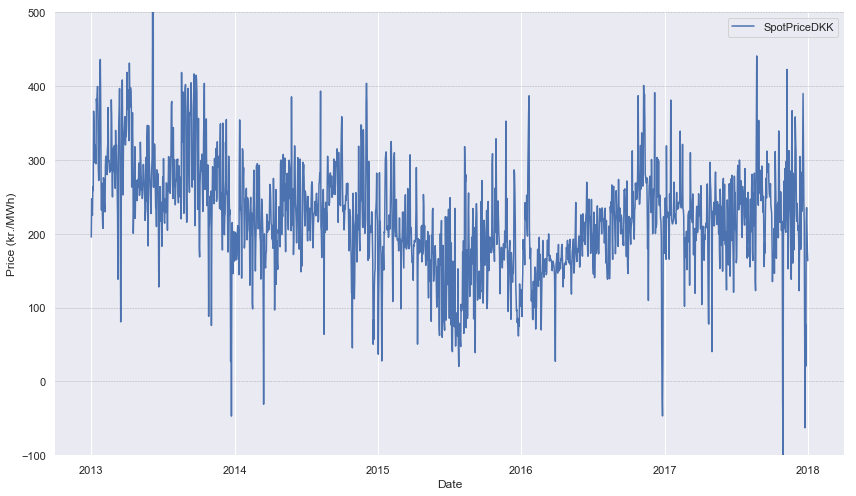

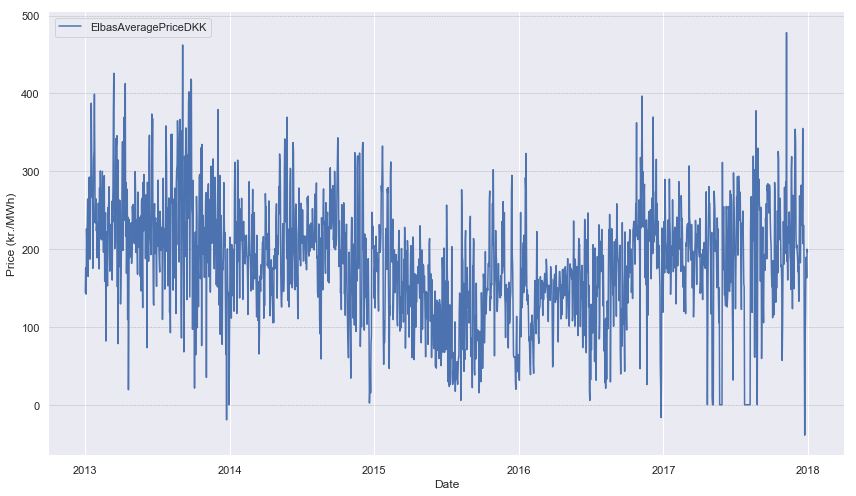

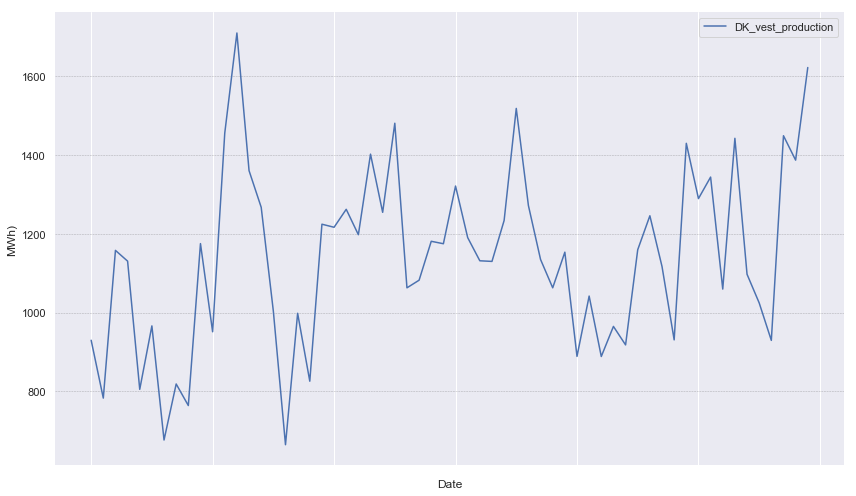

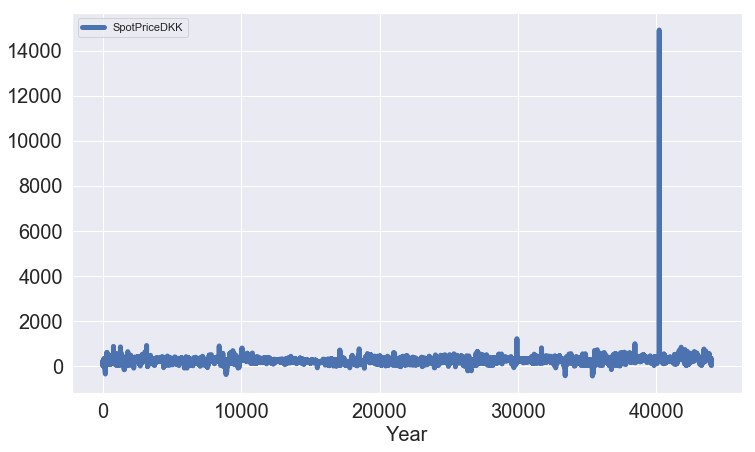

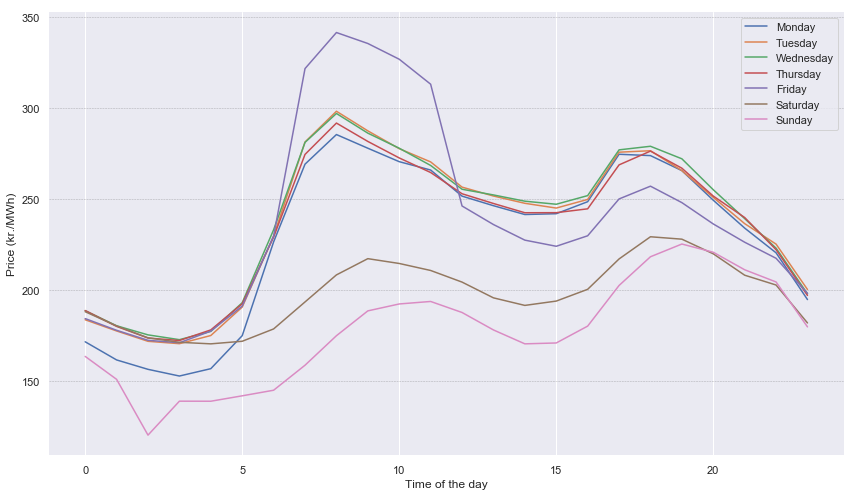

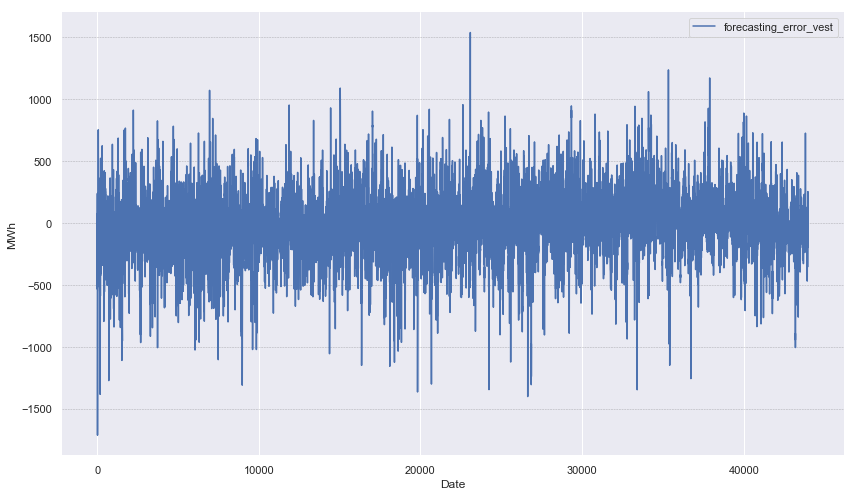

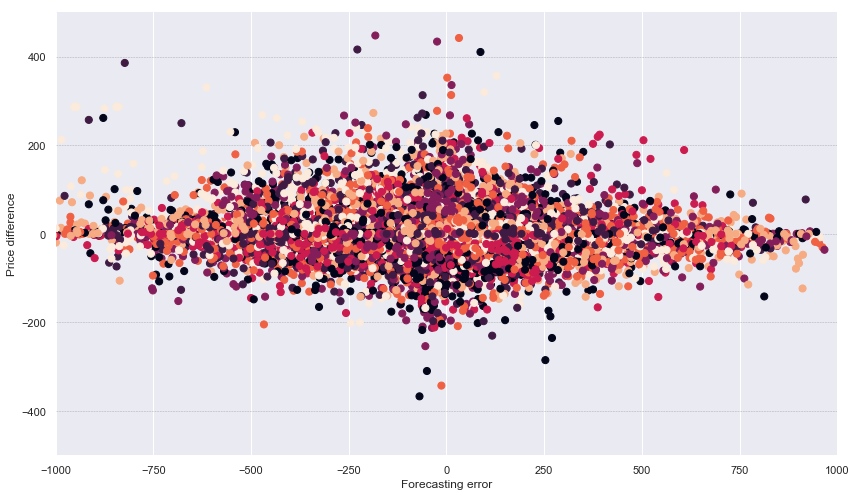

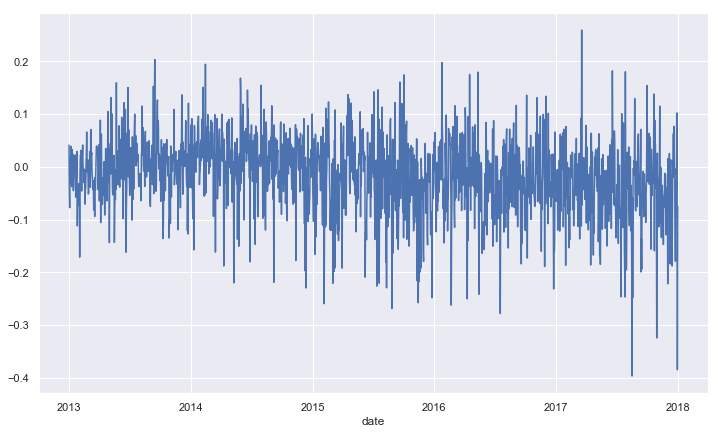

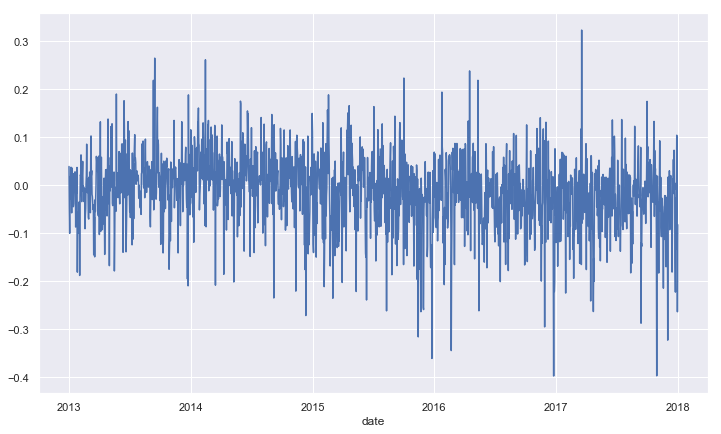

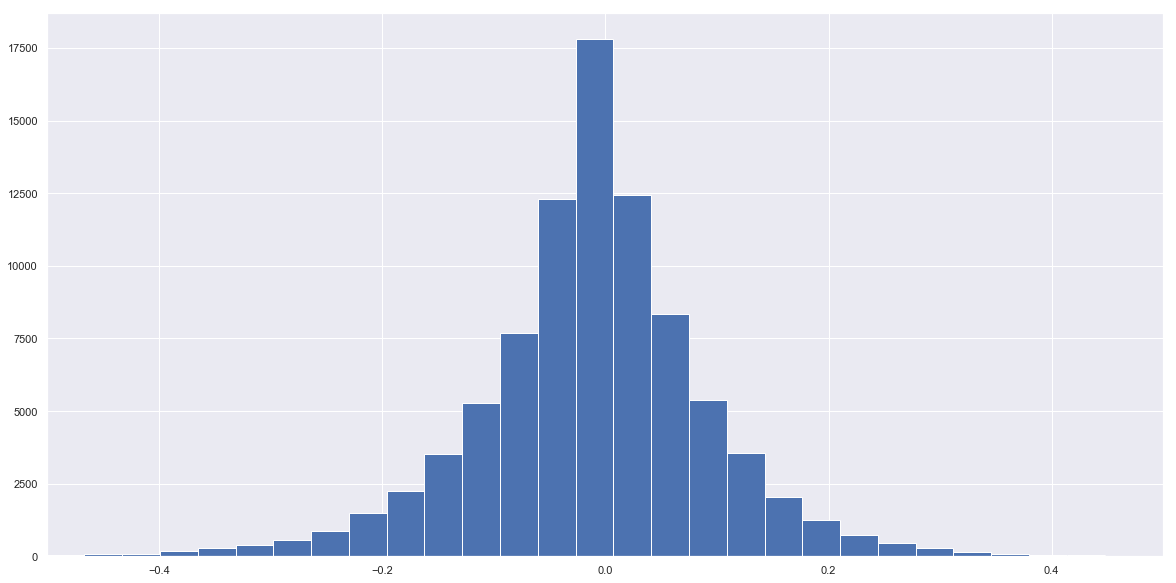

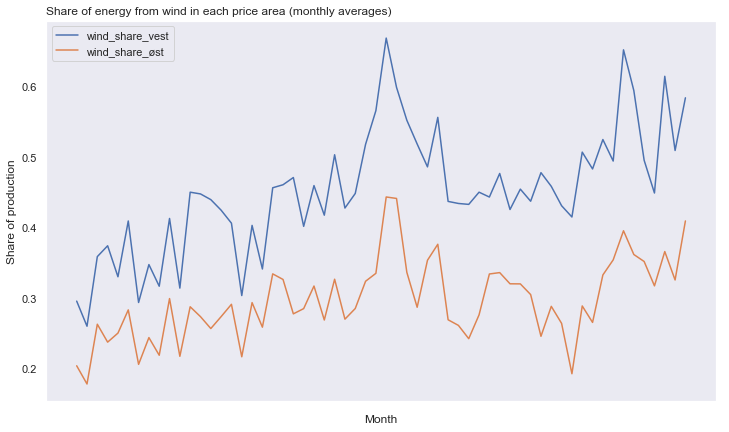

In [7]:
#%% Data description
#Overall development in prices, daily
fig, ax = plt.subplots(figsize=(12,7))
final_vest.groupby(['date']).mean()[['SpotPriceDKK']].plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('Price (kr./MWh)')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.ylim(-100, 500)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True)
fig.tight_layout()
plt.show()

#Overall development in prices, daily
fig, ax = plt.subplots(figsize=(12,7))
final_vest.groupby(['date']).mean()[['ElbasAveragePriceDKK']].plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('Price (kr./MWh)')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True)
fig.tight_layout()
plt.show()

#Overall development in wind power production, monthly
fig, ax = plt.subplots(figsize=(12,7))
final_vest.groupby(['year','month']).mean()[['DK_vest_production']].plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('MWh)')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True)
fig.tight_layout()
plt.show()


#Over 24 hours
final_vest[['SpotPriceDKK']].plot(figsize=(12,7), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

fig, ax = plt.subplots(figsize=(12,7))
final_vest.groupby(['hour','weekday']).mean()['SpotPriceDKK'].unstack().plot(ax=ax)
plt.legend(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.xlabel('Time of the day')
plt.ylabel('Price (kr./MWh)')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True)
fig.tight_layout()
plt.show()

#Prediction errors
fig, ax = plt.subplots(figsize=(12,7))
final_vest[['forecasting_error_vest']].plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('MWh')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True)
fig.tight_layout()
plt.show()



fig, ax = plt.subplots(figsize=(12,7))
plt.scatter(final_vest.forecasting_error_vest, final_vest.price_diff, s=50, c=final_vest.weekday)
plt.xlabel('Forecasting error')
plt.ylabel('Price difference')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([-500,500])
ax.set_xlim([-1000,1000])
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True)

fig.tight_layout()

plt.show()

## Figures based on total dataset (east + west)
# Error shares:

fig, ax = plt.subplots(figsize = (12,7))
final.groupby(["date"]).mean()["forecasting_error_share_vest"].plot(ax = ax)
plt.show()

fig, ax = plt.subplots(figsize = (12,7))
final.groupby(["date"]).mean()["forecasting_error_share_cprog_vest"].plot(ax = ax)
plt.show()

x_norm = np.linspace(-0.5, 0.5, 100)

fig, ax = plt.subplots(figsize = (20,10))
plt.hist(final["forecasting_error_share_cprog_vest"], bins = 51, density = True)
plt.xlim(-0.5,0.5)

plt.show()
#final.forecasting_error_share_cprog_vest.hist(bins = 50)
# final.forecasting_error_share_vest.hist(bins = 50)
# final.forecasting_error_share_øst.hist(bins = 50)

# Wind shares
fig, ax = plt.subplots(figsize = (12,7))
final.groupby(["year","month"]).mean()[["wind_share_vest","wind_share_øst"]].plot(ax = ax)
plt.title("Share of energy from wind in each price area (monthly averages)", loc = "left")
plt.xlabel("Month")
plt.ylabel("Share of production")
plt.grid(False)
plt.show()



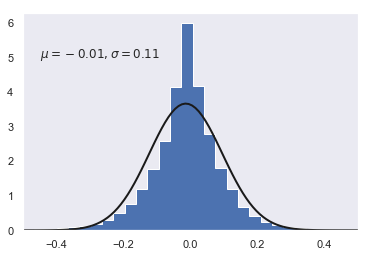

In [75]:
plt.hist(final["forecasting_error_share_cprog_vest"], bins = 51, density = True, histtype = "stepfilled")
p = norm.pdf(x,final.forecasting_error_share_cprog_vest.mean(),np.sqrt(final.forecasting_error_share_cprog_vest.var()))
plt.plot(x, p, 'k', linewidth = 2)
plt.xlim(-0.5, 0.5)
plt.grid(False)
plt.text(-0.45, 5,"$\mu = %.2f, \sigma = %.2f$" % (final.forecasting_error_share_cprog_vest.mean(),np.sqrt(final.forecasting_error_share_cprog_vest.var())))
plt.savefig("ForecastErrorHist.pdf")
plt.show()


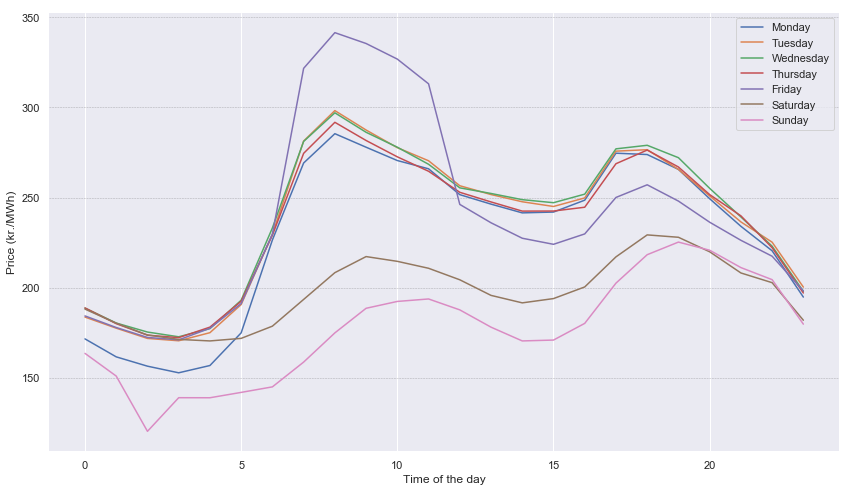

In [76]:
fig, ax = plt.subplots(figsize=(12,7))
final_vest.groupby(['hour','weekday']).mean()['SpotPriceDKK'].unstack().plot(ax=ax)
plt.legend(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.xlabel('Time of the day')
plt.ylabel('Price (kr./MWh)')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=True, left=False, right=False, labelleft=True)
fig.tight_layout()
plt.show()


#### Estimation 

In [7]:
# Estimation; basic model
basic_model = ols("price_diff ~ forecasting_error_vest + outlier + wind_share_vest",
                  data = final_vest).fit()
# print(basic_model.summary())

# Estimation; using error shares:
share_model = ols("price_diff ~ forecasting_error_share_cprog_vest + wind_share_vest + outlier",
                  data = final_vest).fit()
# print(share_model.summary())

# Estimation; adding interaction between wind share and error share
share_model_interaction = ols("price_diff ~ forecasting_error_share_cprog_vest + wind_share_vest + wind_share_vest*forecasting_error_share_cprog_vest + outlier",
                  data = final_vest).fit()
# print(share_model_interaction.summary())

# Estimation; basic model with added calendar-dummies (little theoretical basis for importance of calendar dummies)
calen_model = ols("price_diff ~ forecasting_error_vest + C(month) + C(weekday) + C(hour) + outlier + wind_share_vest"
                  , data = final_vest).fit()
# print(calen_model.summary())

# Estimation; running the share_model for the other price area:
share_model_øst = ols("price_diff ~ forecasting_error_share_cprog_øst + wind_share_øst  + forecasting_error_share_cprog_øst*wind_share_øst",
                  data = final_øst).fit()
# print(share_model.summary())


In [66]:
# This cell produces 
summary_regressions = summary_col([basic_model, calen_model, share_model, share_model_interaction],
                        stars = True, # adds "significance-stars"
                        regressor_order = ["forecasting_error_vest", "wind_share_vest",
                                           "forecasting_error_share_cprog_vest", "wind_share_vest:forecasting_error_share_cprog_vest",
                                          "intercept","outlier"],
                       model_names = ["Basic model", "Calendar model", "Share model", "Share w/interaction"], 
                       drop_omitted = True) # omits variables not specified in regressor_order (i.e. calendar dummmies)
print(summary_regressions)


                                                    Basic model   Calendar model  Share model   Share w/interaction
-------------------------------------------------------------------------------------------------------------------
forecasting_error_vest                             -0.0147***     -0.0146***                                       
                                                   (0.0007)       (0.0007)                                         
wind_share_vest                                    2.0487***      -0.2545        1.7719***      -0.5356            
                                                   (0.6848)       (0.6972)       (0.6839)       (0.7098)           
forecasting_error_share_cprog_vest                                               -36.7506***    21.1198***         
                                                                                 (1.5886)       (5.1188)           
wind_share_vest:forecasting_error_share_cprog_vest                     

#### Show marginal effects 

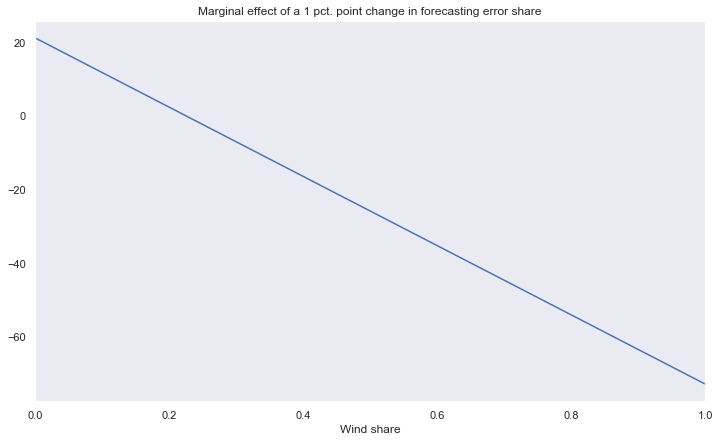

In [77]:
x_marg = np.linspace(start = 0, stop = 1, num = 100)
y_marg = 21.12-93.97*x_marg

fig, ax = plt.subplots(figsize = (12,7))
plt.plot(x_marg, y_marg)
plt.xlabel("Wind share")
plt.title("Marginal effect of a 1 pct. point increase in forecasting error share")
ax.set_xlim([0,1])
plt.grid(False)
plt.show()


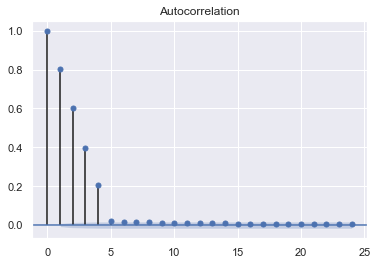

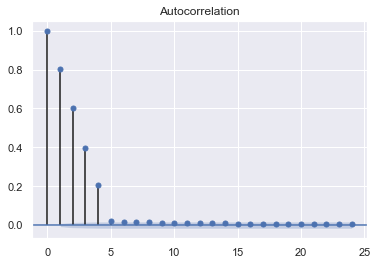

In [77]:
## AR(x) models
# Autocorrelation plot: 
plot_acf(final_vest.price_diff, lags = 24)


In [82]:
price_diff = final_vest.price_diff.values
AR_model = AR(price_diff)
AR_results = AR_model.fit()

In [83]:
print('Lag: %s' % AR_results.k_ar)
print('Coefficients: %s' % AR_results.params)

Lag: 55
Coefficients: [-0.38063383  0.90860702  0.03941395 -0.03947715 -0.02706127 -0.56475766
  0.53448422  0.04993447 -0.04632919 -0.03529789 -0.31752096  0.31906741
  0.04137207 -0.04219775 -0.02689775 -0.18112152  0.19252223  0.02804371
 -0.03309264 -0.01736529 -0.10199673  0.11512523  0.01732618 -0.02590147
 -0.00592629 -0.05945403  0.06780361  0.00985566 -0.01951862  0.00116683
 -0.03565661  0.04021124  0.00462226 -0.01461604  0.00578683 -0.02073314
  0.01988611  0.0043289  -0.01117102  0.00912543 -0.01524051  0.011511
  0.00173997 -0.00833822  0.01117751 -0.01209153  0.00837908 -0.00221188
 -0.00476184  0.00974909 -0.00699492  0.0040049  -0.00267196 -0.00276424
  0.00687087 -0.0034298 ]
